# K-Nearest Neighbor Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split as tts
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
from scipy.stats import mode
import pandas as pd

## 1. Implement the k-nearest neighbor (KNN) algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors
- Implement both the regular (classifcation) version and the regression version
- Include optional distance weighting for both algorithms

In [2]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=None, weight_type='inverse_distance', K=3, eps=1e-10, normalize=False, algorithm='standard'): ## add parameters here
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.normalize = normalize
        self.algorithm = algorithm
        self.column_dicts = None
        self.K = K
        self.eps = eps
        
        
    def fit(self, data, labels):
        if self.columntype is not None:
            data = self.adjust_data(data)
        self.X = data
        self.normal_vals = {'max': data.max(axis=0), 'min': data.min(axis=0)}
        if self.normalize:
            self.X = self.normalize_data(self.X)
        self.y = labels
        self.m, self.n = data.shape
        return self
    
    def find_neighbors_no_weight(self, x):
        distances = np.linalg.norm(x-self.X, axis=1, ord=2)
        if self.algorithm == 'regression':
            return np.mean(self.y[distances.argsort()][:self.K])
        else:
            return mode(self.y[distances.argsort()][:self.K])[0][0]
    
    def find_neighbors_inverse(self, x):
        distances = np.linalg.norm(x-self.X, axis=1, ord=2) #euclidian
        distance_args = distances.argsort()[:self.K] 
        K_distances = distances[distance_args]
        K_neighbors = self.y[distance_args]
        if self.algorithm == 'regression':
            values = []
            weights = []
            for neighbor, distance in zip(K_neighbors, K_distances):
                w = 1 if distance < self.eps else 1 / distance**2
                weights.append(w)
                values.append(neighbor*w)
            return np.array(values).sum()/np.array(weights).sum()
        else:
            votes = {i: 0 for i in set(K_neighbors)}
            for neighbor, distance in zip(K_neighbors, K_distances):
                votes[neighbor] += 1 / (distance**2 + self.eps)
            return max(votes, key=votes.get)
    
    def normalize_data(self, X):
        X = (X - self.normal_vals['min'])/(self.normal_vals['max']- self.normal_vals['min'])
        return X
    
    def predict(self, data):
        if self.normalize:
            data = self.normalize_data(data)
        if self.weight_type == 'no_weight':
            return [self.find_neighbors_no_weight(data[i]) for i in range(len(data))]
        elif self.weight_type == "inverse_distance":
            return [self.find_neighbors_inverse(data[i]) for i in range(len(data))]

    def score(self, X, y):
        if self.columntype is not None:
            X = self.adjust_data(X)
        return np.mean(self.predict(X) == y)
    
    def MSE(self, X, y):
        return np.mean((self.predict(X) - np.array(y))**2)
    
    def create_dictionaries(self, data):
        self.column_dicts = []
        temp = data.T
        for row in range(len(temp)):
            dict_ = {}
            if self.columntype[row] == 'cat':
                for val in set(temp[row]):
                    dict_.update({val: np.mean(temp[row] == val)})
            self.column_dicts.append(dict_)
        
    def adjust_data(self, data):
        if self.column_dicts is None:
            self.create_dictionaries(data)
        df = pd.DataFrame(data, columns=[str(i) for i in range(len(self.columntype))])
        for i in range(len(self.columntype)):
            if self.columntype[i] == 'cat':
                df[str(i)] = df[str(i)].apply(lambda x: self.column_dicts[i][x] if x in list(self.column_dicts[i].keys()) else 0)
            else:
                df[str(i)] = df[str(i)].apply(lambda x: 1 if x == b'?' else x)
        return df.values
    

## Debug and Evaluation

Debug and Evaluate your model using the parameters below:
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance
---

### 1.1 (20%) Debug using this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_test.arff)

Expected Results:
- Not using inverse weighted distancing = roughly [68.29%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_no_inv_predictions.txt)
- Using inverse weighted distancing = roughly [74.39%]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/glass_inv_predictions.txt)

In [3]:
data = pd.DataFrame(arff.loadarff('glass_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('glass_test.arff')[0], dtype=float)
x_train = data.drop(columns='Type').values
y_train = data['Type'].values
x_test = test.drop(columns='Type').values
y_test = test['Type'].values
knn = KNNClassifier()
results = knn.fit(x_train, y_train).score(x_test, y_test)
print(results*100)

74.39024390243902


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  


### 1.2 (20%) Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff) and have your code print the accuracy.

In [4]:
data = pd.DataFrame(arff.loadarff('diabetes_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('diabetes_test.arff')[0], dtype=float)
x_train = data.drop(columns='class').values
y_train = data['class'].values
x_test = test.drop(columns='class').values
y_test = test['class'].values
knn = KNNClassifier()
results = knn.fit(x_train, y_train).score(x_test, y_test)
print(results*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  


89.0625


## 2. KNN with and without normalization

- Use the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) task with this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1 (5%)
- Try it with k=3 and without distance weighting and *without* normalization


In [5]:
data = pd.DataFrame(arff.loadarff('magic_telescope_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('magic_telescope_test.arff')[0], dtype=float)
x_train = data.drop(columns='class').values
y_train = data['class'].values
x_test = test.drop(columns='class').values
y_test = test['class'].values
knn = KNNClassifier(weight_type='no_weight')
results = knn.fit(x_train, y_train).score(x_test, y_test)
print(results*100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  


80.82808280828083


### 2.2 (5%)
- Try it with k=3 without distance weighting and *with* normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [7]:
data = pd.DataFrame(arff.loadarff('magic_telescope_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('magic_telescope_test.arff')[0], dtype=float)
x_train = data.drop(columns='class').values
y_train = data['class'].values
x_test = test.drop(columns='class').values
y_test = test['class'].values
knn = KNNClassifier(normalize=True, weight_type='no_weight')
results = knn.fit(x_train, y_train).score(x_test, y_test)
print(results*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  


83.06330633063307


It appears that Normalized data gives a higher accuracy compared to non Normalized Data

### 2.3 (5%)

- Using your normalized data, create one graph with classification accuracy on the test set on the y-axis and k values on the x-axis. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  


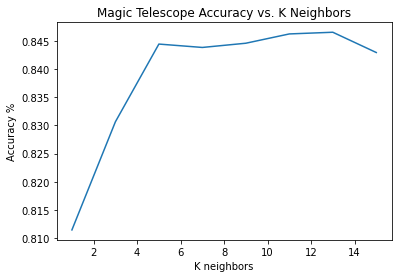

In [8]:
data = pd.DataFrame(arff.loadarff('magic_telescope_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('magic_telescope_test.arff')[0], dtype=float)
x_train = data.drop(columns='class').values
y_train = data['class'].values
x_test = test.drop(columns='class').values
y_test = test['class'].values
scores = []
vals = []
for k in np.arange(1, 16, 2):
    knn = KNNClassifier(K=k, normalize=True, weight_type='no_weight')
    knn.fit(x_train, y_train)
    vals.append(k)
    scores.append(knn.score(x_test, y_test))
fig = plt.figure()
plt.plot(vals, scores)
plt.title("Magic Telescope Accuracy vs. K Neighbors")
plt.ylabel("Accuracy %")
plt.xlabel("K neighbors")
plt.show()

*For the rest of the experiments use only normalized data*

## 3. (10%) KNN regression

- Use the regression variation of your algorithm (without distance weighting) on the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.  Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff). Note this data set has an example of an inappropriate use of data which we will discuss.
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15

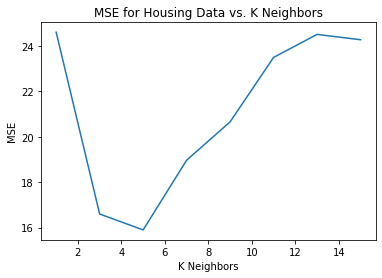

In [9]:
data = pd.DataFrame(arff.loadarff('housing_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('housing_test.arff')[0], dtype=float)
x_train = data.drop(columns='MEDV').values
y_train = data['MEDV'].values
x_test = test.drop(columns='MEDV').values
y_test = test['MEDV'].values
MSEs = []
vals = []
for k in np.arange(1, 16, 2):
    knn = KNNClassifier(K=k, normalize=True, weight_type='no_weight', algorithm='regression')
    knn.fit(x_train, y_train)
    vals.append(k)
    MSEs.append(knn.MSE(x_test, y_test))
fig = plt.figure()
plt.plot(vals, MSEs)
plt.title("MSE for Housing Data vs. K Neighbors")
plt.ylabel("MSE")
plt.xlabel("K Neighbors")
plt.show()

## 4. KNN with distance weighting
- Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.

### 4.1 (7.5%) Magic Telescope Dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  


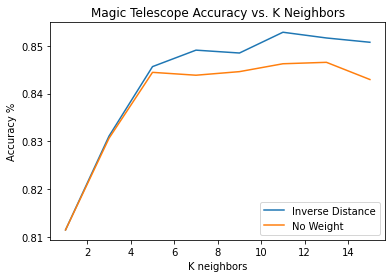

In [10]:
data = pd.DataFrame(arff.loadarff('magic_telescope_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('magic_telescope_test.arff')[0], dtype=float)
x_train = data.drop(columns='class').values
y_train = data['class'].values
x_test = test.drop(columns='class').values
y_test = test['class'].values
scores1 = []
vals = []
for k in np.arange(1, 16, 2):
    knn = KNNClassifier(K=k, normalize=True)
    knn.fit(x_train, y_train)
    vals.append(k)
    scores1.append(knn.score(x_test, y_test))
fig = plt.figure()
plt.plot(vals, scores1, label="Inverse Distance")
plt.plot(vals, scores, label="No Weight")
plt.title("Magic Telescope Accuracy vs. K Neighbors")
plt.ylabel("Accuracy %")
plt.xlabel("K neighbors")
plt.legend()
plt.show()

### 4.2 (7.5%) Housing Dataset

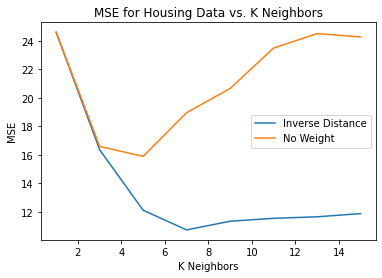

In [11]:
data = pd.DataFrame(arff.loadarff('housing_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('housing_test.arff')[0], dtype=float)
x_train = data.drop(columns='MEDV').values
y_train = data['MEDV'].values
x_test = test.drop(columns='MEDV').values
y_test = test['MEDV'].values
MSEs1 = []
vals = []
for k in np.arange(1, 16, 2):
    knn = KNNClassifier(K=k, normalize=True, algorithm='regression')
    knn.fit(x_train, y_train)
    vals.append(k)
    MSEs1.append(knn.MSE(x_test, y_test))
fig = plt.figure()
plt.plot(vals, MSEs1, label='Inverse Distance')
plt.plot(vals, MSEs, label="No Weight")
plt.title("MSE for Housing Data vs. K Neighbors")
plt.ylabel("MSE")
plt.xlabel("K Neighbors")
plt.legend()
plt.show()

In both cases, When inverse weighting was used, it provided a much better accuracy and MSE for both of the data sets compared to no weights. Both of them seemed to diverge in preformance when it was using mor than 3 neighbors.

## 5. (10%) KNN with nominal and unknown data

- Use the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) task and this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.

In [31]:
data = pd.DataFrame(arff.loadarff('credit_approval.arff')[0], dtype=float)
data['class'] = data['class'].map({b'+':0, b'-':1})
col_types = ['cat', 'num', 'num', 'cat', 'cat', 'cat', 'cat', 'num', 'cat', 'cat', 'num', 'cat', 'cat', 'num', 'num']
X_train, X_test = tts(data)
y_train = X_train['class'].values
X_train = X_train.drop(columns=['class']).values
y_test = X_test['class'].values
X_test = X_test.drop(columns=['class']).values
knn = KNNClassifier(K=7, columntype=col_types, normalize=False)
results = knn.fit(X_train, y_train).score(X_test, y_test)
print(results*100)


69.94219653179191


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """Entry point for launching an IPython kernel.


I tested with 7 because it seemed to be the best accuracy compared to other numbers I tried.

## 6. (10%) Scikit-Learn KNN 
- Use the scikit-learn KNN version on magic telescope and housing and compare your results
- Try out different hyperparameters to see how well you can do. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  after removing the cwd from sys.path.


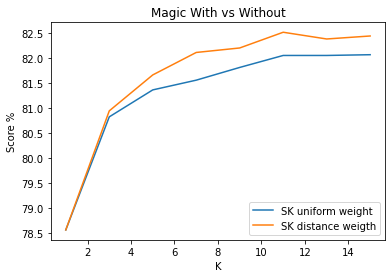

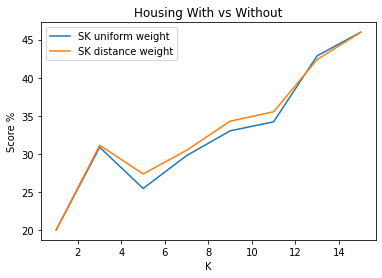

In [19]:
train = pd.DataFrame(arff.loadarff('magic_telescope_train.arff')[0], dtype=float)
X_train = train.drop(columns='class').values
y_train = train['class'].map({b'g':0, b'h':1}).values
test =  pd.DataFrame(arff.loadarff('magic_telescope_test.arff')[0], dtype=float)
X_test = test.drop(columns='class').values
y_test = test['class'].map({b'g':0, b'h':1}).values

m_scores_with = []
m_scores_without = []
for k in np.arange(1,16,2):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    m_scores_without.append(knn.score(X_test, y_test)*100)

    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    m_scores_with.append(knn.score(X_test, y_test)*100)

plt.plot(np.arange(1,16,2), m_scores_with, label='SK uniform weight')
plt.plot(np.arange(1,16,2), m_scores_without, label='SK distance weigth')
plt.title("Magic With vs Without")
plt.xlabel("K")
plt.ylabel("Score %")
plt.legend()
plt.show()


# Load housing price prediction data
train = pd.DataFrame(arff.loadarff('housing_train.arff')[0], dtype=float)
X_train = train.drop(columns='MEDV').values
y_train = train['MEDV'].values
test =  pd.DataFrame(arff.loadarff('housing_test.arff')[0], dtype=float)
X_test = test.drop(columns='MEDV').values
y_test = test['MEDV'].values
h_scores_with = []
h_scores_without = []
for k in np.arange(1,16,2):
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    h_scores_without.append(knn.score(X_test, y_test)*100)

    knn = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    h_scores_with.append(knn.score(X_test, y_test)*100)

plt.plot(np.arange(1,16,2), h_scores_with, label='SK uniform weight')
plt.plot(np.arange(1,16,2), h_scores_without, label='SK distance weight')
plt.title("Housing With vs Without")
plt.xlabel("K")
plt.ylabel("Score %")
plt.legend()
plt.show()

It seems that distance weighting with the classifier seems to behave similarly to the classifier and more than three neighbors provides significant improvement in accuracy. However, there seems to be some improvement in the sk knn regression between 5 and 11 neighbors for distance weighting, but performs roughly similar to uniform once the neighbors are larger than 13.  

## 7. (optional 5% extra credit): Reducing the data set
- Choose either of the data sets above and use the best k value you found.
- Implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.
- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. 
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n^2 at each step.
        - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).

In [ ]:
# Code here

Discussion. How well did it do?